# Notebook to perform a sensitivity calculation

**Content:**
- Calculation of the collection area
- Sensitivity calculation in energy bins
- Sensitivity calculation in bins of gammaness and theta2 cuts
- Optimization of the cuts using Nex/sqrt(Nbg) -> LiMa to be implemented
- Plotting of the sensitivity in absolute values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import pandas as pd
import math

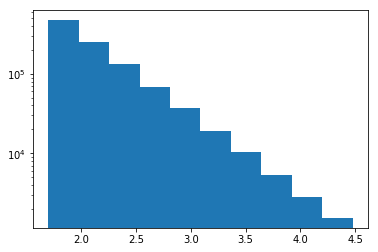

In [2]:
###### Read files #######
filename = "../../cta-lstchain-extra/reco/sample_data/dl2/RandomE_CTA.h5"
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())[0]
e = np.array(f[a_group_key])

# We take as triggered energies an array of 10% the size of the original
e_trig = e[np.random.choice(len(e), size=int(len(e)*0.1), replace=False)]

Simulated_Events = np.size(e)
Triggered_Events = Simulated_Events * 0.1
fig,ax = plt.subplots()
ax.hist(np.log10(e))
ax.set_yscale("log")

In [3]:
##### Binnings and constants######
# Whenever implemented using simulated files, most of these values can be read from the simulations
emin = 50. # GeV
emax = 30.e3 # GeV
eedges = 13
ebins = eedges-1
E = np.logspace(math.log10(emin),math.log10(emax),eedges)
Emed = np.sqrt(E[:-1] * E[1:])

gammaness_bins = 10
theta2_bins = 10

# Maximum impact parameter simulated for low Zd is 350 m, therefore Area_sim is pi*350^2
Max_impact = 350.e2 # in cm
Area_sim = math.pi * math.pow(Max_impact,2) # cm^2

# Weighting of the MC from -2.0 to -2.6
Index_sim = -2.0
Index_Crab = -2.62

# Only applicable for the simulation of diffuse gamma or protons
cone = 0.

In [4]:
##### Collection area calculation ######
def collection_area(Esim, Etrig):
    # Esim are all the simulated energies
    # Etrig are the energies after cuts
    area = []
    Nsim = np.power(Esim,Index_Crab-Index_sim)
    Ncuts = np.power(Etrig,Index_Crab-Index_sim)
    
    for i in range(0,ebins):
        Nsim_w = np.sum(Nsim[(Esim < E[i+1]) & (Esim > E[i])])
        Ntrig_w = np.sum(Ncuts[(Etrig < E[i+1]) & (Etrig > E[i])])
        if(Nsim_w == 0):
            print("You have not simulated any events in the energy range between %.3f GeV and %.3f GeV" % (E[i],E[i+1]))
            area.append(0)
        else:
            area.append(Ntrig_w / Nsim_w * Area_sim) # cm^2

    return area


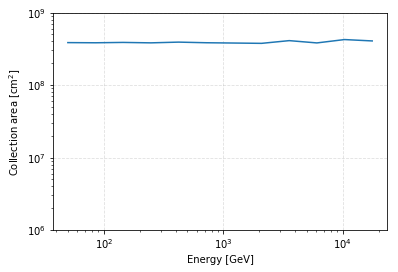

In [5]:
# Plot the collection area
area = collection_area(e, e_trig)
fig, ax = plt.subplots()
ax.set_ylim(1.e6,1.e9)
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Collection area [cm$^2$]")
ax.grid(ls='--',alpha=0.4)
ax.loglog(E[:-1], area)

In [19]:
# Fake energy, gammaness and theta2 arrays for simulated and triggered events
# (To be substituted by real np.array with all the simulated/triggered)

gammaness = np.random.random_sample((int(Simulated_Events),))
gammaness_trig = np.random.random_sample((int(Triggered_Events),))

theta2 = 0.5 * np.random.random_sample((int(Simulated_Events),)) # maximum 0.5 deg^2
theta2_trig = 0.5 * np.random.random_sample((int(Triggered_Events),))  # maximum 0.5 deg^2


# Same for hadrons
gammaness_h = np.random.random_sample((int(Simulated_Events),))
gammaness_trig_h = np.random.random_sample((int(Triggered_Events),))

theta2_h = 0.5 * np.random.random_sample((int(Simulated_Events),))  # maximum 0.5 deg^2
theta2_trig_h = 0.5 * np.random.random_sample((int(Triggered_Events),))  # maximum 0.5 deg^2

In [20]:
####### Sensitivity calculation ##########
# We will first go for a implementation using Sig = Nex/sqrt(Nbg)
obstime = 50 * 3600 # s (50 hours)

In [21]:
####### Weighting of the hadrons #####
# No simulation, just take the gamma energy distribution and convert it to hadrons

#Float_t ProtonTrueSpectralIndex = -2.70;
#Float_t ProtonTrueNorm = 9.6e-9;  // (cm2 sr s GeV)^-1 at ProtonEnorm                                                                                                              
#Float_t ProtonEnorm    = 1000.; // GeV     

K = Simulated_Events*(1+Index_sim)/(emax**(1+Index_sim)-emin**(1+Index_sim))                    
Max_impact_protons = 500.e2 #cm
Area_sim = math.pi * math.pow(Max_impact_protons,2) # cm^2
cone = 5. * math.pi/180 # 5 deg
if(cone == 0):
    Omega = 1
else:
    Omega = 2*np.pi*(1-np.cos(cone))

K_w = 9.6e-9 # GeV^-1 cm^-2 s^-1                                          
index_w = -2.7                                                  
E0 = 1000. # GeV                                              
                                                    
Int_e1_e2 = K*E0**Index_sim                                                
Np_ = Int_e1_e2*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)           
Rp = K_w*Area_sim*Omega*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1) # Rate (in Hz)
print("The total rate of simulated proton events is %.1f Hz" % Rp)


The total rate of simulated proton events is 172672.8 Hz


In [22]:
####### Weighting of the gamma simulations #####

# HEGRA Crab
#  TF1* CrabFluxHEGRA = new TF1("CrabFluxHEGRA","[0]*pow(x/1000.,-[1])",50,80000);
#  CrabFluxHEGRA->SetParameter(0,2.83e-11);
#  CrabFluxHEGRA->SetParameter(1,2.62);

K = Simulated_Events*(1+Index_sim)/(emax**(1+Index_sim)-emin**(1+Index_sim))                    
Area_sim = math.pi * math.pow(Max_impact,2) # cm^2
cone=0
if(cone == 0):
    Omega = 1
else:
    Omega = 2*np.pi*(1-np.cos(cone))


K_w = 2.83e-14 # GeV^-1 cm^-2 s^-1                                          
index_w = -2.62                                                  
E0 = 1000. # GeV                                              
                                                    
Int_e1_e2 = K*E0**Index_sim                                                
N_ = Int_e1_e2*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1)                       
R = K_w*Area_sim*Omega*(emax**(index_w+1)-emin**(index_w+1))/(E0**index_w)/(index_w+1) # Rate (in Hz)
print("The total rate of simulated gamma events is %.2f Hz" % (R))

The total rate of simulated gamma events is 8.61 Hz


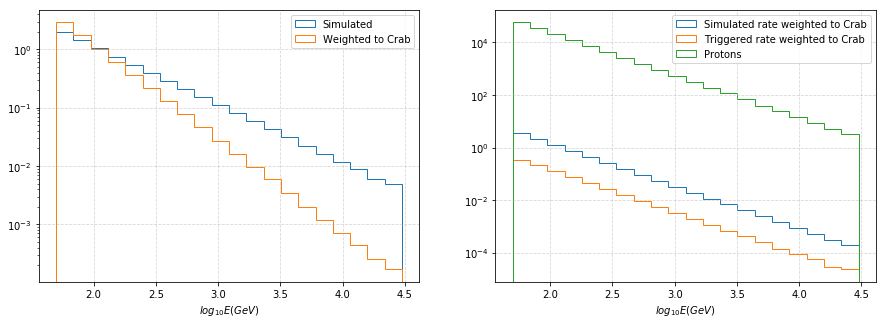

In [37]:
e_w = ((e/E0)**(index_w-Index_sim))*R/N_
e_trig_w = ((e_trig/E0)**(index_w-Index_sim))*R/N_
ep_w = ((e/E0)**(index_w-Index_sim))*Rp/Np_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.hist(np.log10(e),histtype=u'step',bins=20, density=1,label="Simulated")
ax1.hist(np.log10(e),histtype=u'step',bins=20,weights = e_w, density=1,label="Weighted to Crab")
ax1.set_yscale('log')
#plt.xscale('log')
ax1.set_xlabel("$log_{10}E (GeV)$")
ax1.grid(ls='--',alpha=.5)
ax1.legend()

#ax2.hist(np.log10(e),histtype=u'step',bins=20,label="Simulated rate")
ax2.hist(np.log10(e),histtype=u'step',bins=20,weights = e_w,label="Simulated rate weighted to Crab")
ax2.hist(np.log10(e_trig),histtype=u'step',bins=20,weights = e_trig_w,label="Triggered rate weighted to Crab")
ax2.hist(np.log10(e),histtype=u'step',bins=20,weights = ep_w,label="Protons")
ax2.legend()
ax2.set_yscale('log')
ax2.set_xlabel("$log_{10}E (GeV)$")
ax2.grid(ls='--',alpha=.5)
#plt.xscale('log')

In [38]:
# Number of gammas per bin without any cuts in theta2 or gammaness
for i in range(0,ebins): # binning in energy
    e_w_sum = np.sum(e_w[(e < E[i+1]) & (e > E[i])])
    print("Rate of gammas between %.1f GeV and %.1f GeV: %.2f Hz" % (E[i],E[i+1],e_w_sum))

Rate of gammas between 50.0 GeV and 85.2 GeV: 4.98 Hz
Rate of gammas between 85.2 GeV and 145.2 GeV: 2.10 Hz
Rate of gammas between 145.2 GeV and 247.5 GeV: 0.88 Hz
Rate of gammas between 247.5 GeV and 421.7 GeV: 0.37 Hz
Rate of gammas between 421.7 GeV and 718.7 GeV: 0.16 Hz
Rate of gammas between 718.7 GeV and 1224.7 GeV: 0.07 Hz
Rate of gammas between 1224.7 GeV and 2087.2 GeV: 0.03 Hz
Rate of gammas between 2087.2 GeV and 3556.9 GeV: 0.01 Hz
Rate of gammas between 3556.9 GeV and 6061.5 GeV: 0.00 Hz
Rate of gammas between 6061.5 GeV and 10329.9 GeV: 0.00 Hz
Rate of gammas between 10329.9 GeV and 17603.9 GeV: 0.00 Hz
Rate of gammas between 17603.9 GeV and 30000.0 GeV: 0.00 Hz


In [39]:
# Cut optimization for gammas and hadrons

final_gamma = np.ndarray(shape=(ebins,gammaness_bins,theta2_bins))
final_hadrons = np.ndarray(shape=(ebins,gammaness_bins,theta2_bins))

for i in range(0,eedges-1): # binning in energy
    e_w_binE = np.sum(e_w[(e < E[i+1]) & (e > E[i])])
    for g in range(0,gammaness_bins): # cut in gammaness
        Ngammas = []
        Nhadrons = []
        for t in range(0,theta2_bins): # cut in theta2
            e_trig_w_sum = np.sum(e_trig_w[(e_trig < E[i+1]) & (e_trig > E[i]) \
                                         & (gammaness_trig > 0.1*g) & (theta2_trig < 0.05*(t+1))])
            # Just considering all the hadrons give trigger...
            ep_w_sum = np.sum(ep_w[(e < E[i+1]) & (e > E[i]) \
                                         & (gammaness_h > 0.1*g) & (theta2_h < 0.05*(t+1))])
            
            final_gamma[i][g][t] = e_trig_w_sum * obstime
            final_hadrons[i][g][t] = ep_w_sum * obstime


In [40]:
def Calculate_sensititity(Ng, Nh, alpha):
    significance = (Ng)/np.sqrt(Nh * alpha)
    sensitivity = 5/significance * 100 # percentage of Crab
    
    return sensitivity
sens = Calculate_sensititity(final_gamma, final_hadrons, 1)

In [41]:
def fill_bin_content(ax,energy_bin):
    for i in range(0,gammaness_bins):
        for j in range(0,theta2_bins):
            text = ax.text((j+0.5)*0.05, (i+0.5)*0.1, "%.2f %%" % sens[energy_bin][i][j],
                       ha="center", va="center", color="w")
    return ax

In [42]:
def format_axes(ax,pl):
    ax.set_aspect(0.5)

    ax.set_ylabel(r'Gammaness',fontsize=15)
    ax.set_xlabel(r'$\theta^2$ (deg$^2$)',fontsize=15)
    
    starty, endy = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(endy, starty, 0.1)[::-1])
    startx, endx = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(startx, endx, 0.1))

    cbaxes = fig.add_axes([0.9, 0.125, 0.03, 0.755])
    cbar = fig.colorbar(pl,cax=cbaxes)
    cbar.set_label('Sensitivity (% Crab)',fontsize=15) 

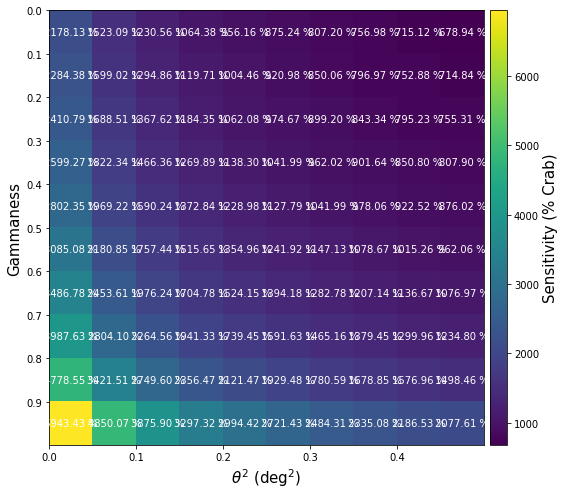

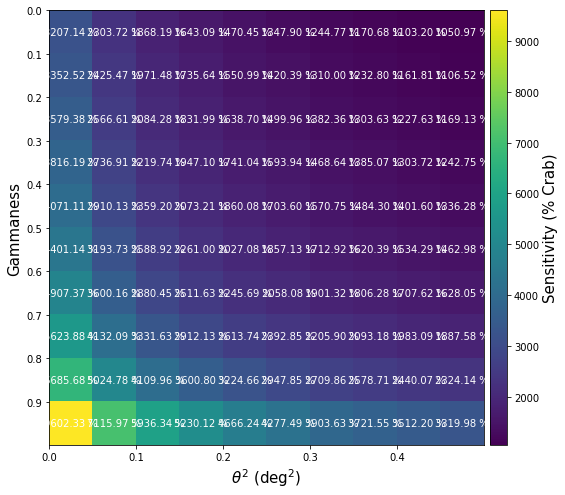

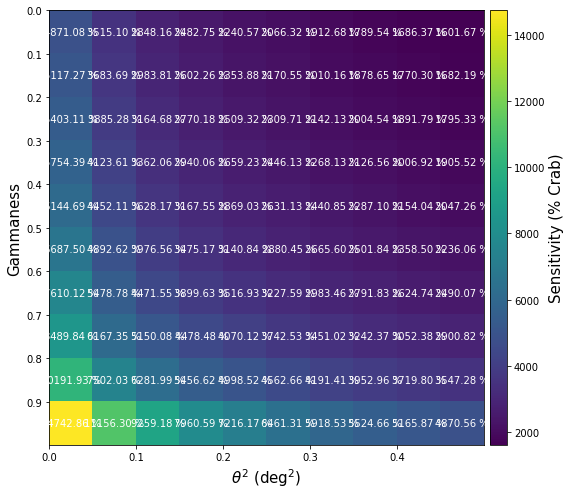

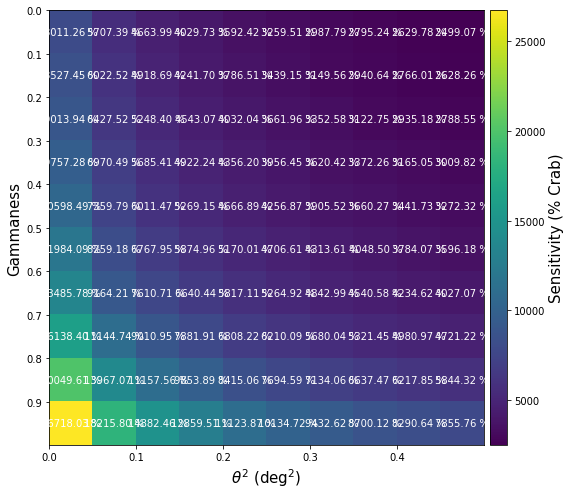

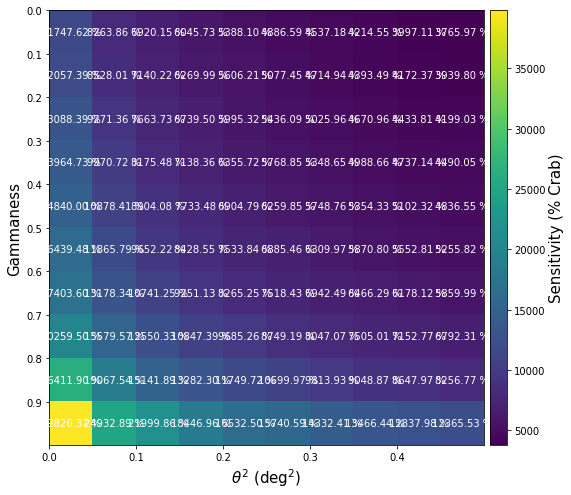

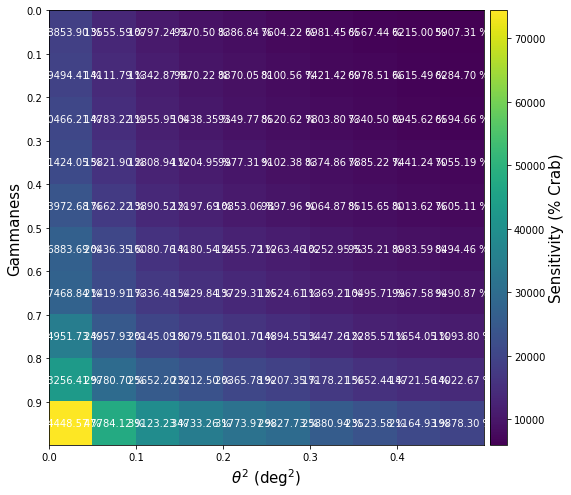

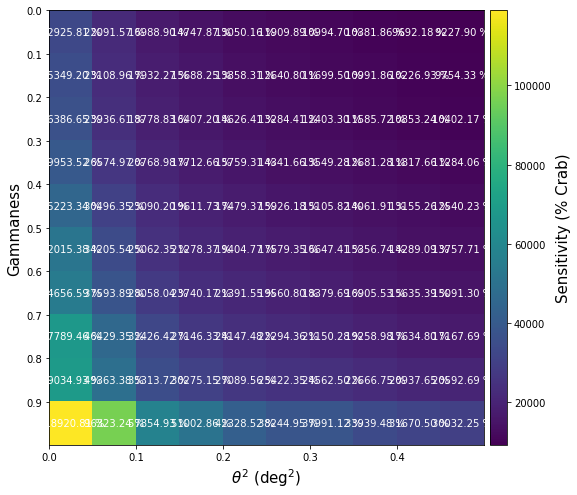

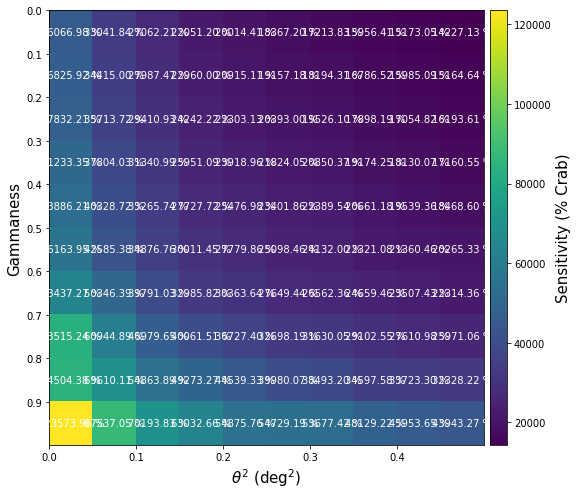

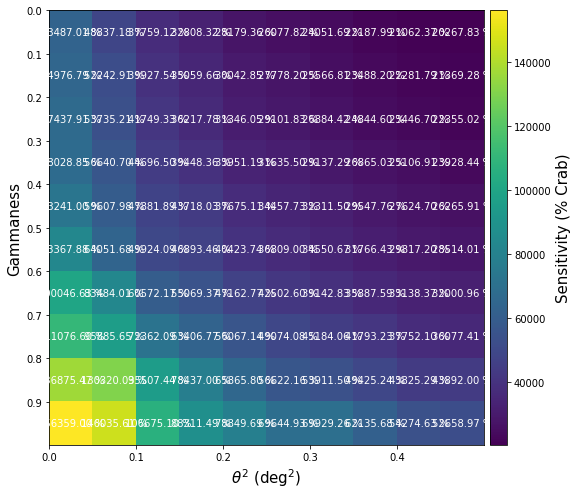

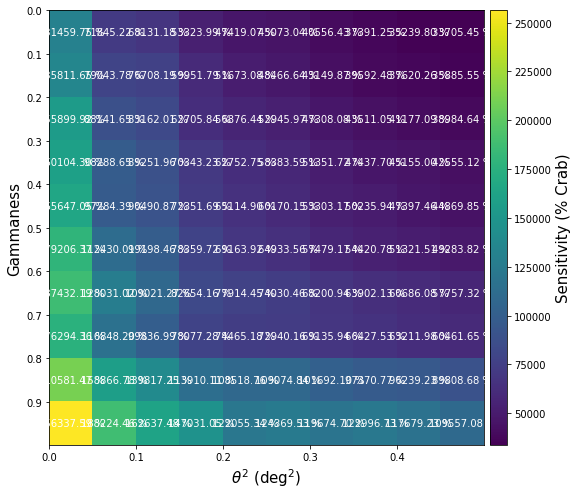

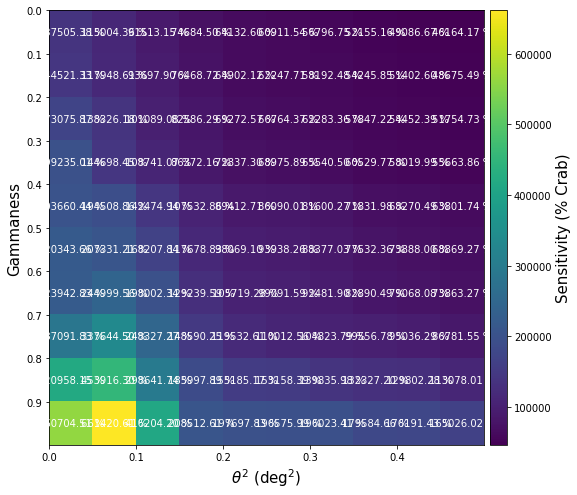

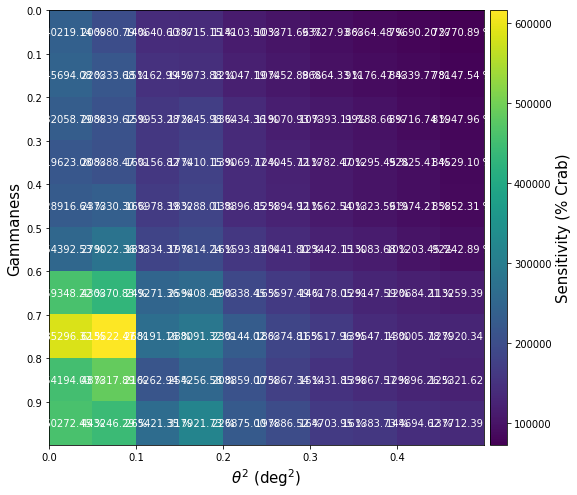

In [43]:
# Sensitivity plots for different Energy bins
for ebin in range(0,ebins):
    fig, ax = plt.subplots(figsize=(8,8))
    pl = ax.imshow(sens[ebin], cmap='viridis', extent=[0., 0.5, 1., 0.])
    fill_bin_content(ax, ebin)

    format_axes(ax, pl)

In [44]:
def format_axes_array(ax, arr_i,arr_j):
    ax.set_aspect(0.5)
    if ((arr_i == 0) and (arr_j == 0)):
        ax.set_ylabel(r'Gammaness',fontsize=15)
    if ((arr_i == 3) and (arr_j == 2)):
        ax.set_xlabel(r'$\theta^2$ (deg$^2$)',fontsize=15)

    starty, endy = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(endy, starty, 0.1)[::-1])
    startx, endx = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(startx, endx, 0.1))
    
    cbaxes = fig.add_axes([0.91, 0.125, 0.03, 0.755])
    cbar = fig.colorbar(pl,cax=cbaxes)
    cbar.set_label('Sensitivity (% Crab)',fontsize=15) 

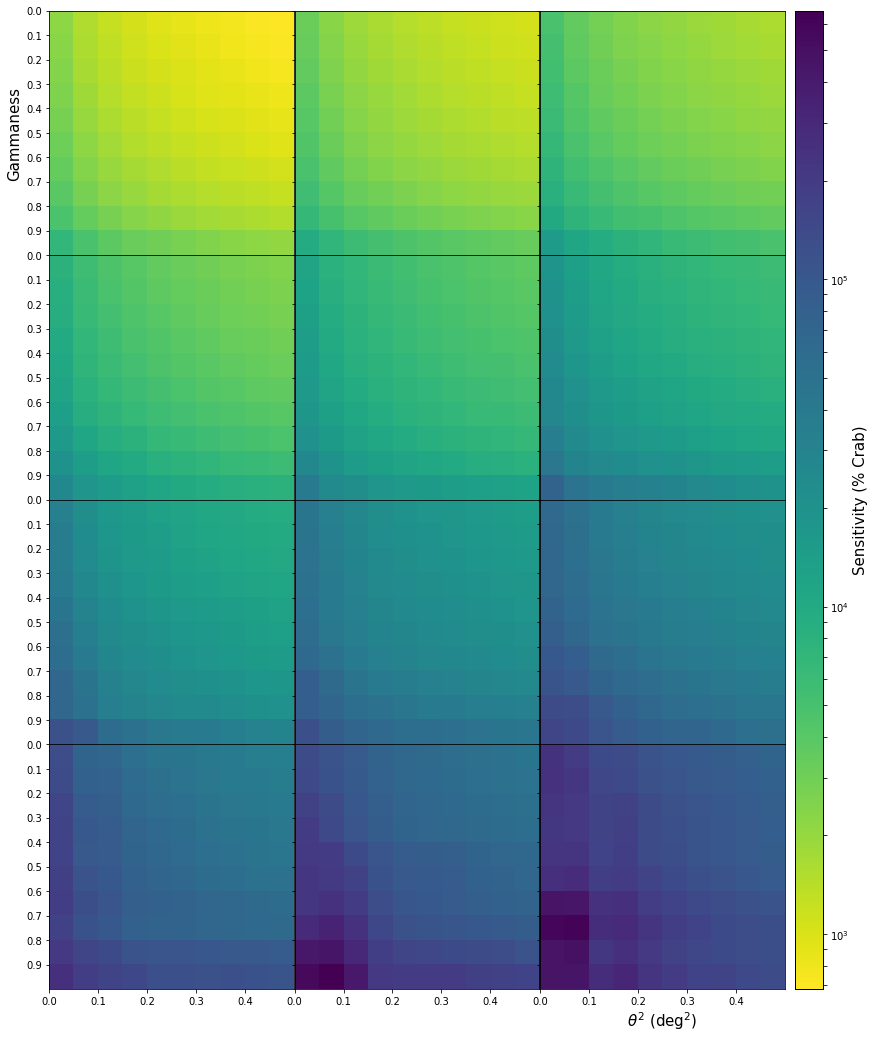

In [45]:
#fig, ax = plt.subplots(figsize=(8,8), )
fig, axarr = plt.subplots(4,3, sharex=True, sharey=True, figsize=(13.2,18))
indices=[]
sensitivity = np.ndarray(shape=ebins)

for ebin in range(0,ebins):
    arr_i = int(ebin/3)
    arr_j = ebin-int(ebin/3)*3
    pl = axarr[arr_i,arr_j].imshow(sens[ebin], cmap='viridis_r', extent=[0., 0.5, 1., 0.],
                                   #vmin=sens.min(), vmax=sens.max())
                                  norm=LogNorm(vmin=sens.min(), vmax=sens.max()))
    format_axes_array(axarr[arr_i,arr_j],arr_i,arr_j)

    # gammaness/theta2 indices where the minimum in sensitivity is reached
    ind = np.unravel_index(np.argmin(sens[ebin], axis=None), sens[ebin].shape)
    indices.append(ind)
    sensitivity[ebin] = sens[ebin][ind]
    
fig.subplots_adjust(hspace = 0, wspace = 0)
#format_axes(ax)

In [46]:
def Crab_spectrum(x):
    MAGIC_par=[3.23e-11, -2.47, -0.24]
    #dFdE = MAGIC_par[0]*pow(x/1.,MAGIC_par[1]+MAGIC_par[2]*np.log10(x/1.))
    dFdE = MAGIC_par[0]*pow(x/1000.,MAGIC_par[1]+MAGIC_par[2]*np.log10(x/1000.))
    
    return dFdE

In [47]:
def plot_Crab(ax, percentage=100, **kwargs):
    # factor is the percentage of Crab                                                                                                                                                                      
    En = np.logspace(math.log10(100),math.log10(3.e4),40) # in TeV
    dFdE = percentage / 100. * Crab_spectrum(En)
    ax.loglog(En,dFdE * En/1.e3 * En/1.e3, color='gray', **kwargs)
    
    return ax

In [48]:
def format_axes(ax):
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(5e1,9.e4)
    ax.set_ylim(1.e-14,5.e-10)
    ax.set_xlabel("Energy [GeV]")
    ax.set_ylabel(r'E$^2$ $\frac{\mathrm{dN}}{\mathrm{dE}}$ [TeV cm$^{-2}$ s$^{-1}$]')
    ax.grid(ls='--',alpha=.5)

In [49]:
def plot_sensitivity(ax):
    dFdE = Crab_spectrum(Emed)
    ax.loglog(Emed, sensitivity / 100 * dFdE * Emed/1.e3 * Emed/1.e3, label = 'Sensitivity')
    

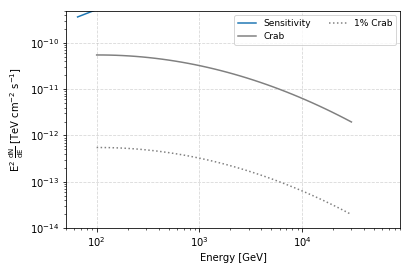

In [50]:
#### SENSITIVITY PLOT ######
fig, ax = plt.subplots()
plot_sensitivity(ax)

plot_Crab(ax, label=r'Crab')
#plot_Crab(ax,10,ls='dashed',label='10% Crab')
plot_Crab(ax,1,ls='dotted',label='1% Crab')


format_axes(ax)
ax.legend(numpoints=1,prop={'size':9},ncol=2,loc='upper right')